# IMPORT LIBRARIES TO USE

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
import matplotlib.pyplot as plt
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l2

# IMPORT DATA FROM PREVIOUS NOTEBOOK

In [2]:

input_data_all = pd.read_csv("DSCVR_KP_all_cleaned_extended_fp32_vF1.csv")
input_data_all = input_data_all[input_data_all.columns.difference(['datetime_DSCVR'])].astype('float32')
input_data_all

,FarCup10_max,FarCup10_mean,FarCup10_mean_MISSING,FarCup10_median,FarCup10_min,FarCup10_nan,FarCup10_range,FarCup11_max,FarCup11_mean,FarCup11_mean_MISSING,...,MagFieldVect_Comp2_nan,MagFieldVect_Comp2_range,MagFieldVect_Comp3_max,MagFieldVect_Comp3_mean,MagFieldVect_Comp3_mean_MISSING,MagFieldVect_Comp3_median,MagFieldVect_Comp3_min,MagFieldVect_Comp3_nan,MagFieldVect_Comp3_range,ap
0,426.765015,368.099976,0.0,366.541992,324.664001,0.000000,102.100998,556.234009,468.313232,0.0,...,0.0,11.858230,3.951090,0.045978,0.0,0.416581,-6.34188,0.0,10.292970,7.0
1,415.463013,364.331451,0.0,364.493500,342.971985,0.000000,72.490997,525.554993,455.946320,0.0,...,0.0,14.817100,6.693190,-0.228962,0.0,-1.765580,-4.58207,0.0,11.275260,9.0
2,403.501007,373.022003,0.0,370.944000,355.575012,0.000000,47.925999,495.877991,462.863617,0.0,...,0.0,10.493590,4.529970,-1.294382,0.0,-1.125145,-5.97934,0.0,10.509310,7.0
3,386.549011,345.861664,0.0,342.160004,325.760986,0.133333,60.787998,483.414001,427.346436,0.0,...,0.0,4.627597,3.822480,-0.144519,0.0,-0.011839,-5.35283,0.0,9.175310,5.0
4,373.752014,348.120911,0.0,345.104492,333.983002,0.000000,39.769001,480.266998,437.506805,0.0,...,0.0,6.550520,3.639030,-0.555546,0.0,-0.772677,-3.89034,0.0,7.529370,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18036,1.815680,0.314818,0.0,0.231726,0.231726,0.000000,1.583954,92.655998,78.150291,0.0,...,0.0,4.712220,3.997020,0.267391,0.0,0.337352,-2.54975,0.0,6.546770,4.0
18037,0.598153,0.244910,0.0,0.231726,0.231726,0.000000,0.366427,85.245003,76.922165,0.0,...,0.0,7.848990,4.365540,1.438682,0.0,1.526950,-2.17326,0.0,6.538800,4.0
18038,19.656401,0.934255,0.0,0.255987,0.231726,0.000000,19.424673,93.291603,76.422363,0.0,...,0.0,6.791530,2.371470,-0.925729,0.0,-1.537770,-3.15406,0.0,5.525530,6.0
18039,40.391800,28.505920,0.0,29.143150,0.750516,0.000000,39.641285,102.954002,79.010612,0.0,...,0.0,3.958778,0.383127,-1.601845,0.0,-1.569085,-3.11466,0.0,3.497787,3.0


# SPLIT INTO X AND Y

In [3]:
datasetX_input = input_data_all.drop(columns = ['Kp', 'ap','Kp_class'], axis=1).copy()
datasetY_input = input_data_all['Kp']
print(datasetX_input.shape)
print(datasetY_input.shape)

(18041, 371)
(18041,)


# SPLIT INTO TRAIN AND TEST

In [4]:
# TRAIN TEST SPLIT
pct_split = 0.9

datasetX_input_TRAIN = datasetX_input[0:int(pct_split*datasetX_input.shape[0])]
datasetY_input_TRAIN = datasetY_input[0:int(pct_split*datasetY_input.shape[0])]

datasetX_input_TEST = datasetX_input[int(pct_split*datasetX_input.shape[0]):]
datasetY_input_TEST = datasetY_input[int(pct_split*datasetY_input.shape[0]):]


In [5]:
print(datasetX_input_TRAIN.shape)
print(datasetY_input_TRAIN.shape)
print(datasetX_input_TEST.shape)
print(datasetY_input_TEST.shape)


(16236, 371)
(16236,)
(1805, 371)
(1805,)


# STANDARIZE DATA

In [6]:
scaler = StandardScaler()
datasetX_input_TRAIN_scaled = scaler.fit_transform(datasetX_input_TRAIN)
datasetX_input_TEST_scaled = scaler.transform(datasetX_input_TEST)

# CREATE AND USE FUNCTION TO PREPARE DATASET FOR TRAINING
- It creates the X-train set comprised of X-variables including the past y-values for a user-specified window.
- It creates the y-train dataset by providing for each window, the next user-defined look_forward period values.
- Each sequence finally has a set of historical y-values and X-values as predictor variables, in order to estimate the future y-values.

In [7]:
look_back = 240  # looking at the past look_back time steps
look_forward = 8  # predicting the next look_forward time steps

def create_dataset(datasetX, datasetY, look_back=100, look_forward=12):
    X, Y = [], []
    for i in range(1, len(datasetX)-look_back-look_forward+1):
        # print(i)
        x_set = datasetX[i:(i+look_back), :]  #
        y_set = datasetY[i-1:(i+look_back)-1, -1]    # Previous y values
        X.append(np.hstack((x_set, y_set.reshape(-1,1))))
        Y.append(datasetY[i + look_back:i + look_back + look_forward, -1])
    return np.array(X), np.array(Y)


In [8]:
X_train, y_train = create_dataset(np.array(datasetX_input_TRAIN_scaled), np.array(datasetY_input_TRAIN).reshape(-1,1), 240, 8)

In [9]:
print(X_train.shape)
print(y_train.shape)

(15988, 240, 372)
(15988, 8)


# AT THIS POINT, SEVERAL TRIALS HAVE BEEN PERFORMED TRANSFORMING THE TARGET VARIABLE, SQUARED, SQUARE-ROOT, EXPONENTIAL, AGGREGATION OF Kp VALUES LESS THAN 5 OR 6 VS REST, ETC...

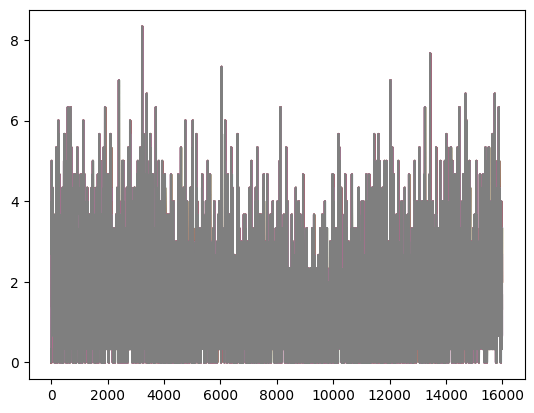

In [10]:
plt.plot(y_train)

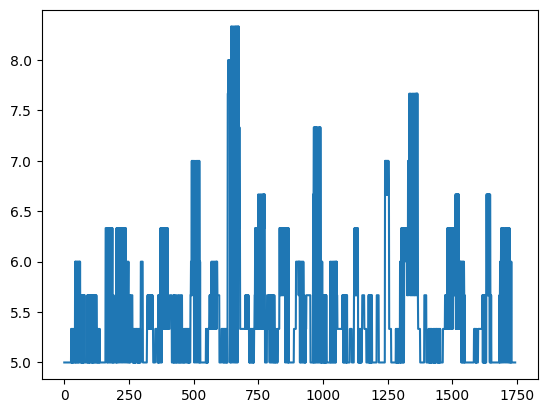

In [11]:
set_label_lim = 5
plt.plot(y_train[y_train>=set_label_lim])

In [12]:
# y_train = y_train**0.5
y_train[y_train<set_label_lim] = 0
y_train[y_train>=set_label_lim] = 1

In [13]:
np.sum(y_train==1)

1744

#

# LSTM DEEP LEARNING MODEL ARCHITECTURE
- We have tried several simplified model architectures based on LSTM, providing similar results.
- Among the best ones, below is defined an example architecture using LSTM as basis.

In [20]:

tf.keras.backend.set_floatx('float32')

model = keras.Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.05))
# model.add(Dense(50, activation='linear'))
model.add(Dense(look_forward, activation='sigmoid')) # for
opt = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt) # loss='mean_squared_error'

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=2, shuffle=False)

Epoch 1/50
125/125 - 5s - loss: 0.1221 - 5s/epoch - 40ms/step
Epoch 2/50
125/125 - 3s - loss: 0.0769 - 3s/epoch - 21ms/step
Epoch 3/50
125/125 - 3s - loss: 0.0733 - 3s/epoch - 22ms/step
Epoch 4/50
125/125 - 3s - loss: 0.0708 - 3s/epoch - 21ms/step
Epoch 5/50
125/125 - 3s - loss: 0.0688 - 3s/epoch - 22ms/step
Epoch 6/50
125/125 - 3s - loss: 0.0667 - 3s/epoch - 23ms/step
Epoch 7/50
125/125 - 3s - loss: 0.0639 - 3s/epoch - 22ms/step
Epoch 8/50
125/125 - 3s - loss: 0.0624 - 3s/epoch - 22ms/step
Epoch 9/50
125/125 - 3s - loss: 0.0601 - 3s/epoch - 21ms/step
Epoch 10/50
125/125 - 3s - loss: 0.0583 - 3s/epoch - 21ms/step
Epoch 11/50
125/125 - 3s - loss: 0.0562 - 3s/epoch - 21ms/step
Epoch 12/50
125/125 - 3s - loss: 0.0544 - 3s/epoch - 22ms/step
Epoch 13/50
125/125 - 3s - loss: 0.0516 - 3s/epoch - 21ms/step
Epoch 14/50
125/125 - 3s - loss: 0.0492 - 3s/epoch - 21ms/step
Epoch 15/50
125/125 - 3s - loss: 0.0485 - 3s/epoch - 22ms/step
Epoch 16/50
125/125 - 3s - loss: 0.0476 - 3s/epoch - 22ms/step
E

# TEST DATASET CREATION USING FUNCTION DEFINED ABOVE

In [30]:
X_test, y_test = create_dataset(np.array(datasetX_input_TEST_scaled), np.array(datasetY_input_TEST).reshape(-1,1), 240, 8)

# PERFORM SAME TRANSFORMATION OVER Y AS ABOVE (IF-ANY)

In [31]:
y_test[y_test<set_label_lim] = 0
y_test[y_test>=set_label_lim] = 1

# USE MODEL TO PREDICT TRAIN DATASET FIRST

In [32]:
results_predict_train = model.predict(X_train)
print(results_predict_train.shape)
print(np.max(results_predict_train))
results_predict_train

500/500 [==============================] - 4s 8ms/step
(15988, 8)
0.99615884


array([[3.6758574e-06, 3.7654685e-05, 1.3048991e-04, ..., 8.8383886e-04,
        2.1165574e-03, 3.3491866e-03],
       [2.5321715e-06, 1.2103770e-05, 5.4598855e-05, ..., 8.0342806e-04,
        8.9753733e-04, 7.3031161e-04],
       [3.1946379e-06, 1.1675776e-05, 5.5925277e-05, ..., 5.6418730e-04,
        3.4887204e-04, 2.2481814e-04],
       ...,
       [7.5382944e-05, 1.6340360e-04, 3.2171246e-04, ..., 5.2848613e-05,
        2.4629058e-05, 2.0616619e-05],
       [7.6497854e-05, 3.3471579e-04, 4.8091938e-04, ..., 2.0351847e-05,
        2.2924731e-05, 4.1598367e-05],
       [9.7803124e-05, 2.7132090e-04, 7.4961461e-04, ..., 3.1700780e-05,
        1.9169294e-05, 1.8730479e-05]], dtype=float32)

BEST TRAIN THRESHOLD: 0.020202020202020204


Text(0, 0.5, 'ROC-AUC')

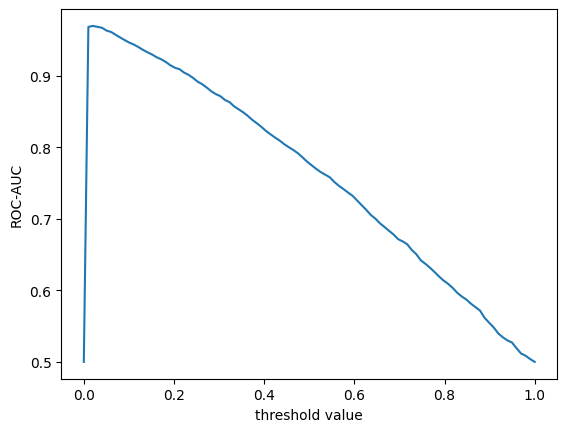

In [33]:
list_rocaucs = []
list_thresholds = np.linspace(0,1,100)

for threshold_val in list_thresholds:
  results_predict_train_loop = np.copy(results_predict_train)
  results_predict_train_loop[results_predict_train_loop<threshold_val] = 0
  results_predict_train_loop[results_predict_train_loop>=threshold_val] = 1
  list_rocaucs.append(roc_auc_score(y_train, results_predict_train_loop))

print("BEST TRAIN THRESHOLD:", list_thresholds[np.argmax(list_rocaucs)])
best_train_threshold = list_thresholds[np.argmax(list_rocaucs)]
plt.plot(list_thresholds, list_rocaucs)
plt.xlabel("threshold value")
plt.ylabel("ROC-AUC")

In [34]:
threshold = 0.05
results_predict_train[results_predict_train<threshold] = 0
results_predict_train[results_predict_train>=threshold] = 1

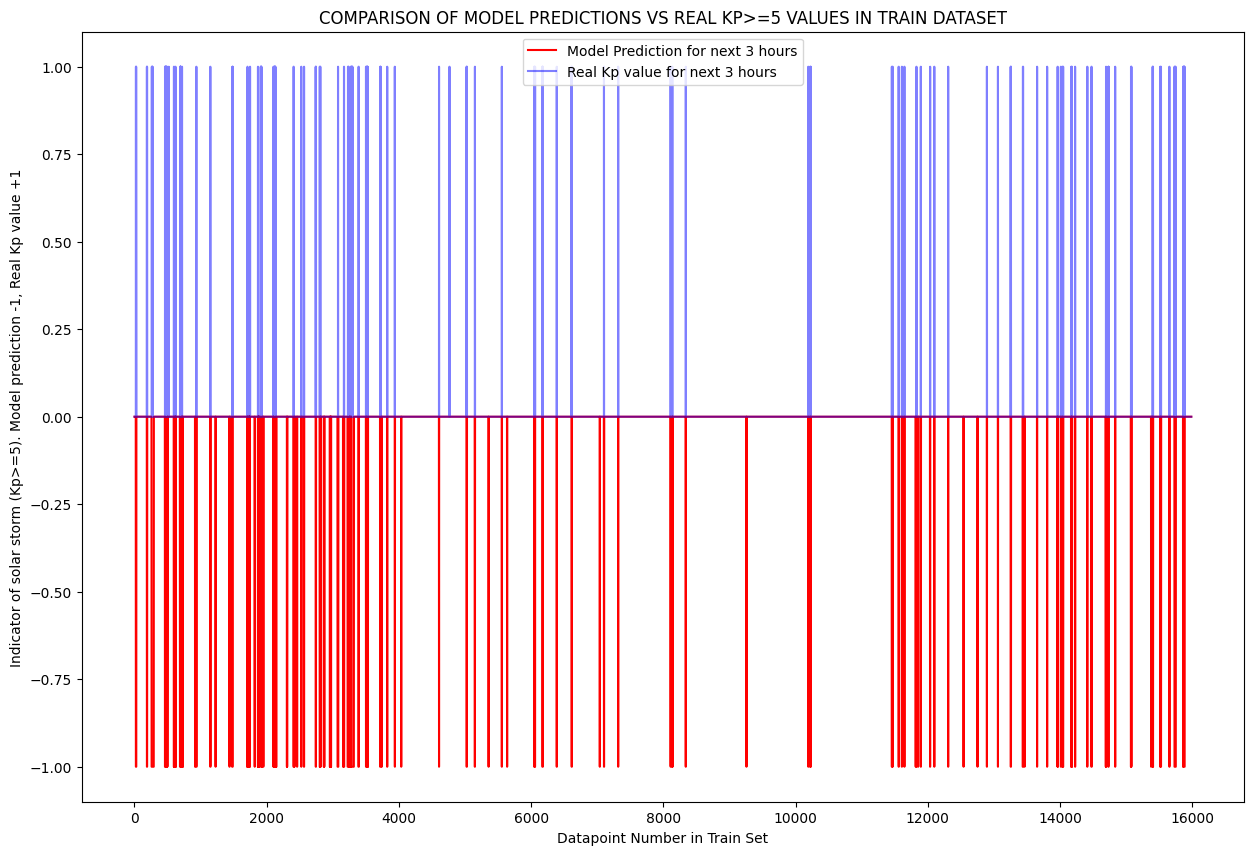

In [35]:
# TRAIN
prediction_point_ahead = 0
plt.figure(figsize=(15,10))
plt.plot(-results_predict_train[:,prediction_point_ahead], color='red', label = 'Model Prediction for next 3 hours')
plt.plot(y_train[:,prediction_point_ahead], alpha=0.5, color='blue', label = 'Real Kp value for next 3 hours')
plt.xlabel("Datapoint Number in Train Set")
plt.ylabel("Indicator of solar storm (Kp>=5). Model prediction -1, Real Kp value +1")
plt.title("COMPARISON OF MODEL PREDICTIONS VS REAL KP>=5 VALUES IN TRAIN DATASET")
plt.legend()

# USE MODEL TO PREDICT TEST DATASET SECONDLY

In [36]:
results_predict_test = model.predict(X_test)
print(results_predict_test.shape)
print(np.max(results_predict_test))
results_predict_test

49/49 [==============================] - 0s 8ms/step
(1557, 8)
0.85279


array([[3.5391195e-06, 2.2085067e-05, 4.5654324e-05, ..., 2.8465402e-06,
        1.4135051e-06, 5.6140698e-06],
       [5.1057223e-06, 4.1958650e-05, 5.7600926e-05, ..., 2.1413571e-06,
        1.3836599e-06, 6.5671820e-06],
       [4.3933173e-06, 2.4419205e-05, 4.1966334e-05, ..., 3.5020898e-06,
        1.9339320e-06, 7.3188962e-06],
       ...,
       [6.5115955e-08, 2.3340739e-07, 1.5872816e-06, ..., 1.4884145e-05,
        8.2837605e-06, 1.3447545e-05],
       [4.9322274e-08, 2.4662680e-07, 1.2999822e-06, ..., 7.8181847e-06,
        4.2332122e-06, 8.3116465e-06],
       [1.5239313e-07, 3.5305996e-07, 1.4495571e-06, ..., 7.8770381e-06,
        4.7556514e-06, 1.1342701e-05]], dtype=float32)

In [37]:
results_predict_test[results_predict_test<threshold] = 0
results_predict_test[results_predict_test>=threshold] = 1

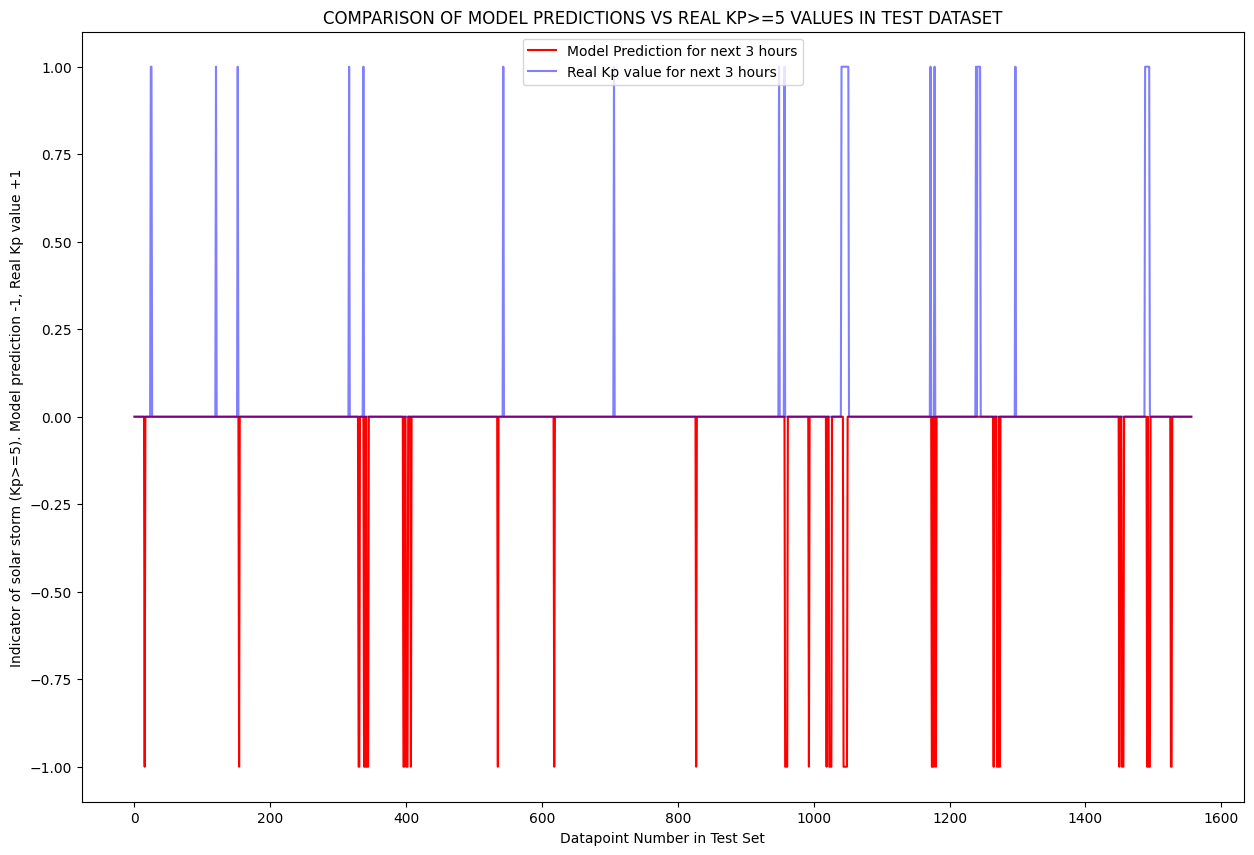

In [38]:
# TEST
prediction_point_ahead = 0
plt.figure(figsize=(15,10))
plt.plot(-results_predict_test[:,prediction_point_ahead], color='red', label = 'Model Prediction for next 3 hours')
plt.plot(y_test[:,prediction_point_ahead], alpha=0.5, color='blue', label = 'Real Kp value for next 3 hours')
plt.xlabel("Datapoint Number in Test Set")
plt.ylabel("Indicator of solar storm (Kp>=5). Model prediction -1, Real Kp value +1")
plt.title("COMPARISON OF MODEL PREDICTIONS VS REAL KP>=5 VALUES IN TEST DATASET")
plt.legend()